# Timelag Maps: Observed
Compute timelags from observed AIA data

In [10]:
import os
import sys
import glob

import numpy as np
import distributed
import matplotlib.pyplot as plt
import matplotlib.colors
from sunpy.map import Map,GenericMap
import astropy.units as u
from astropy.utils.console import ProgressBar

sys.path.append('../../scripts/')
from timelags import AIATimeLagsObserved
from idl_colormaps import bgry_004_idl_cmap

%matplotlib inline

In [2]:
cluster = distributed.LocalCluster(threads_per_worker=1)
client = distributed.Client(cluster)#processes=False)
client

Client Scheduler: tcp://127.0.0.1:38549 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 64 Cores: 64 Memory: 270.38 GB


## Load Data
The first thing we need to do is import our timelag map into an HDF5 datacube. Note that these maps have already been scaled to a common resolution, derotated and cropped to the appropriate active region.

In [3]:
aia_timelags = AIATimeLagsObserved(
    '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/timelags/mapcube.h5',
    #fits_root_path='/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/aia/cutouts/'
)

In [4]:
channels = ['94','131','171','193','211','335']

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


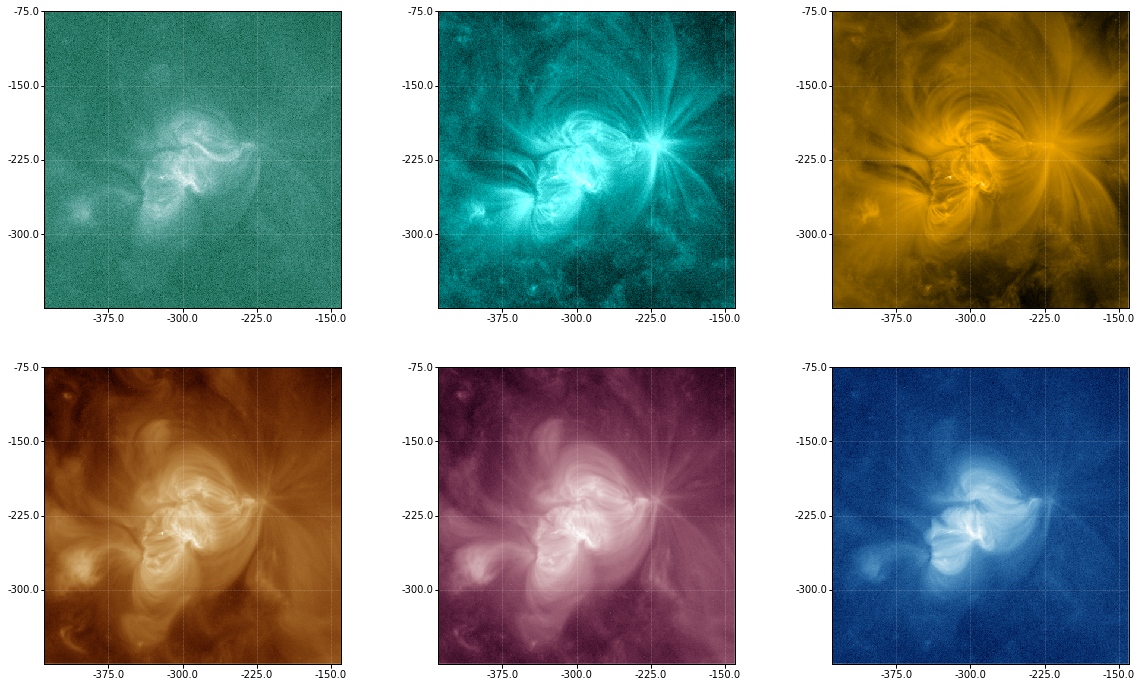

In [5]:
fig = plt.figure(figsize=(20,12))
for i, c in enumerate(channels):
    m = Map(np.array(aia_timelags.get_data(c)[:,:,0]), aia_timelags.get_metadata(c))
    ax = fig.add_subplot(2,3,i+1, projection=m)
    m.plot(title=False,axes=ax,annotate=False)

## Compute Timelags: 1D

In [5]:
xc,yc = -300*u.arcsec, -230*u.arcsec
dx,dy = 1*u.arcsec, 1*u.arcsec
lower_left_corner = (xc-dx/2,yc-dy/2)
upper_right_corner = (xc+dx/2,yc+dy/2)
coords  = (lower_left_corner,upper_right_corner)

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


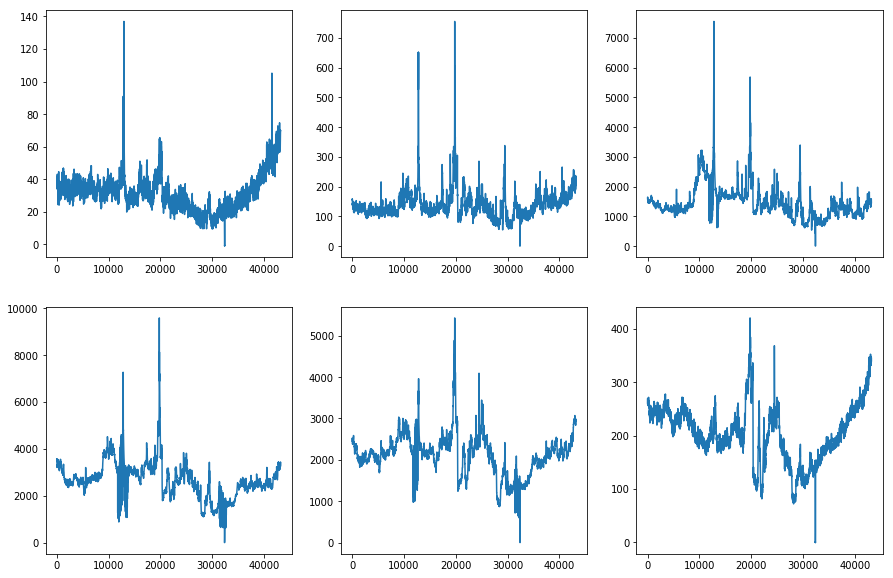

In [7]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
for i,(channel,ax) in enumerate(zip(channels, axes.flatten())):
    ts = aia_timelags.make_timeseries(channel, lower_left_corner, upper_right_corner)
    ax.plot(aia_timelags.observing_time, ts,color='C0')

In [6]:
channel_pairs = [(94,335),
                 (94,171),
                 (94,193),
                 (94,131),
                 (94,211),
                 (335,131),
                 (335,193),
                 (335,211), 
                 (335,171),
                 (211,131),
                 (211,171),
                 (211,193),
                 (193,171),
                 (193,131),
                 (171,131),]

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.6/site-packages/sunpy/map/sources/sdo.py:48: SunpyDeprecationWarning: Use Matplotlib to load the colormaps
  self.plot_settings['cmap'] = cm.get_cmap(self._get_cmap_name())


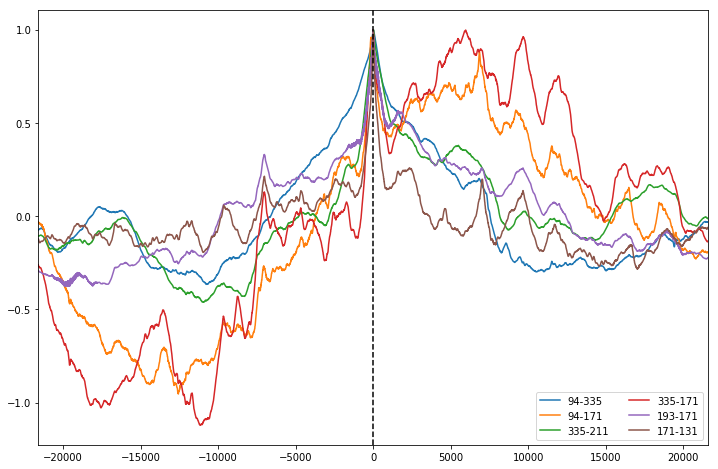

In [9]:
fig = plt.figure(figsize=(12,8),)
ax = fig.gca()
for i,p in enumerate(channel_pairs):
    cc = aia_timelags.correlation_1d(f'{p[0]}', f'{p[1]}', *coords)
    ax.plot(aia_timelags.timelags, cc/cc.max(), color=f'C{i}', ls='-', label='{}-{}'.format(*p))
ax.axvline(x=0,ls='--',color='k')
ax.set_xlim(-(6*u.hr).to(u.s).value, (6*u.hr).to(u.s).value)
ax.legend(loc=4,ncol=2)

## Compute Timelags: 2D Maps

In [11]:
timelag_bounds = (-6*u.hour,6*u.hour)

In [12]:
timelag_maps = {}
correlation_maps = {}
with ProgressBar(len(channel_pairs),ipython_widget=True) as prog:
    for p in channel_pairs:
        tl_map, cor_map = aia_timelags.make_timelag_map(f'{p[0]}',f'{p[1]}', timelag_bounds=timelag_bounds, return_correlation_map=True)
        timelag_maps['{}-{}'.format(*p)] = tl_map
        correlation_maps['{}-{}'.format(*p)] = cor_map
        prog.update()

FloatProgress(value=0.0)

In [14]:
correlation_cutoff = 500.

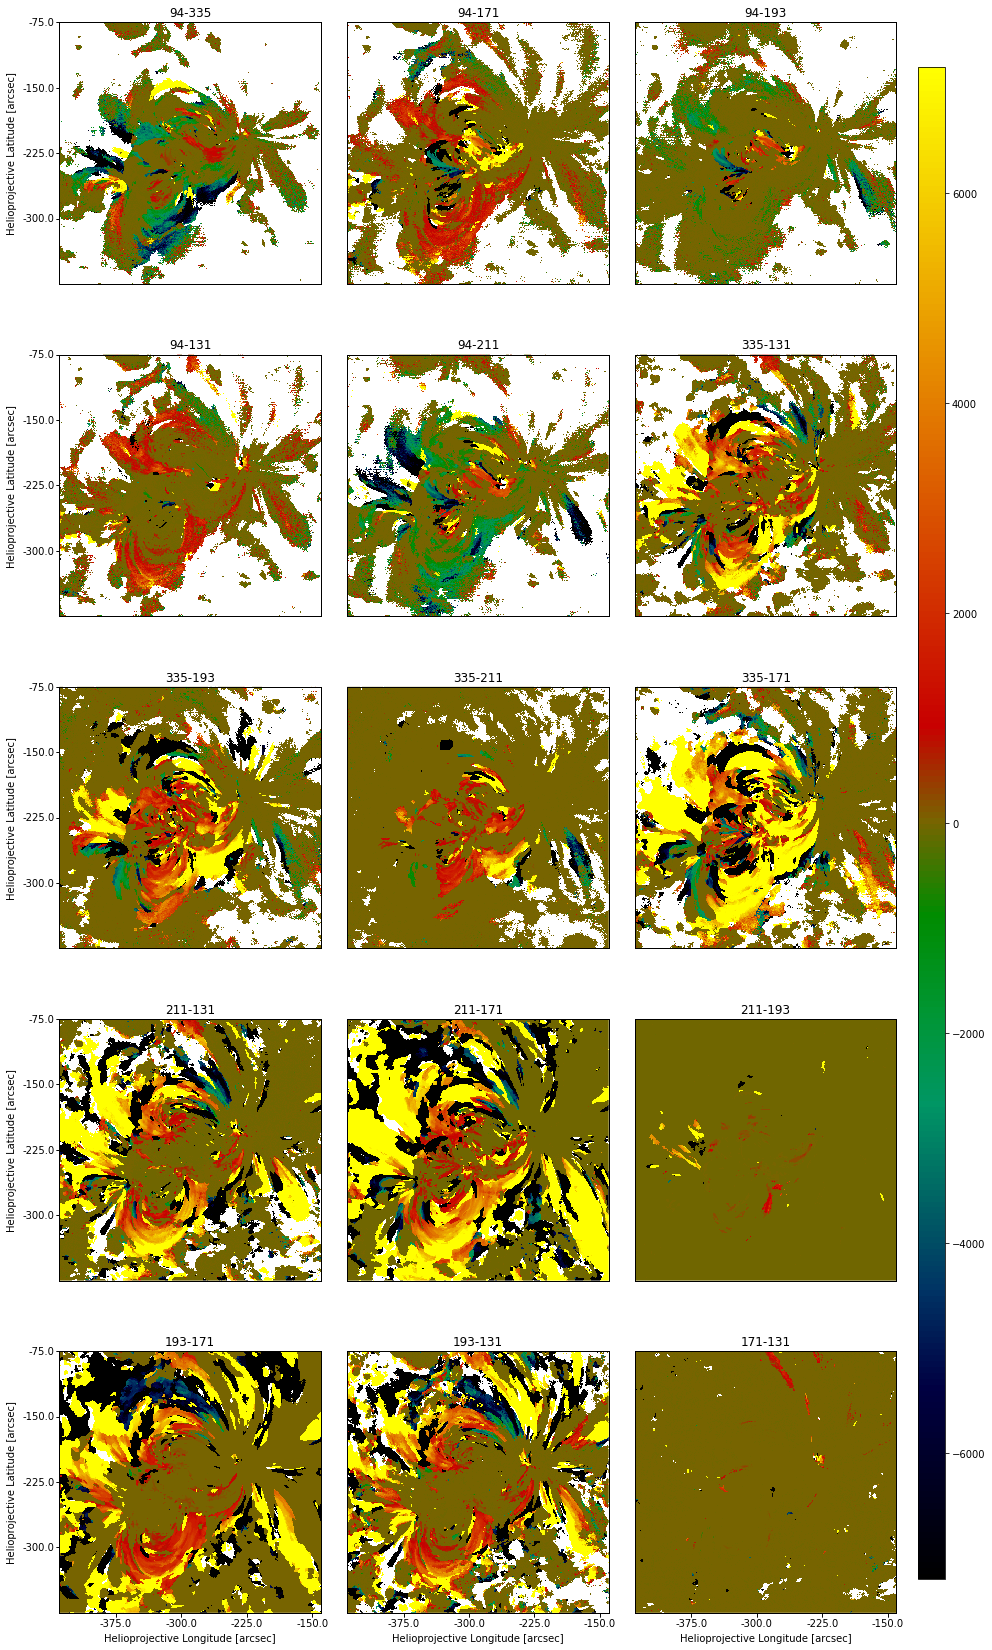

In [15]:
fig = plt.figure(figsize=(15,30))
cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
for i,cp in enumerate(channel_pairs):
    m = Map(timelag_maps['{}-{}'.format(*cp)])
    m_cor = Map(correlation_maps['{}-{}'.format(*cp)])
    data = np.where((m_cor.data) < correlation_cutoff, np.nan, m.data)
    m = Map(data, m.meta)
    ax = fig.add_subplot(5, 3, i+1, projection=m)
    im = m.plot(axes=ax, title=False, annotate=False,
                vmin=-(2*u.hour).to(u.s).value,
                vmax=(2*u.hour).to(u.s).value,
                cmap=bgry_004_idl_cmap)
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if i % 3 == 0:
        lat.set_axislabel(r'Helioprojective Latitude [arcsec]')
    else:
        lat.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
    if i > 11:
        lon.set_axislabel(r'Helioprojective Longitude [arcsec]')
    else:
        lon.set_ticklabel_visible(False)
        lon.set_ticks_visible(False)
    ax.set_title('{}-{}'.format(*cp))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
cbar = fig.colorbar(im, cax=cax)

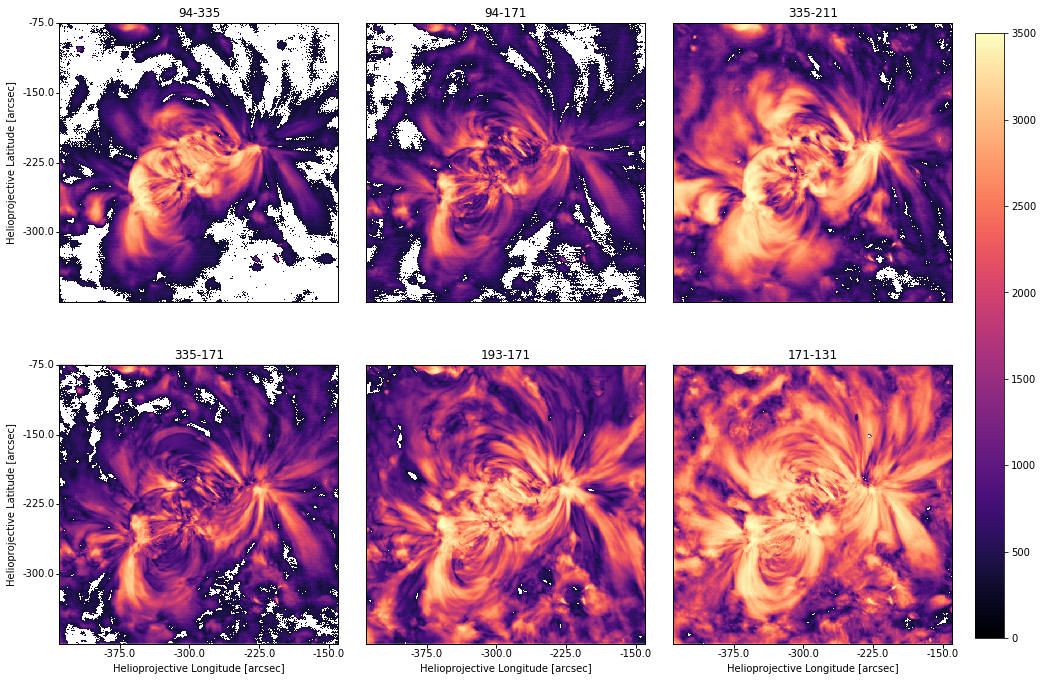

In [22]:
fig = plt.figure(figsize=(16,12))
cax = fig.add_axes([0.92, 0.15, 0.025, 0.7])
for i,cp in enumerate(channel_pairs):
    m = correlation_maps['{}-{}'.format(*cp)]
    data = m.data #/ m.data.max()
    data = np.where(data < 300., np.nan, data)
    m = Map(data, m.meta)
    ax = fig.add_subplot(2, 3, i+1, projection=m)
    im = m.plot(axes=ax, title=False, annotate=False,
                vmin=0, vmax=3.5e3,
                cmap='magma')
    ax.grid(alpha=0)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if i % 3 == 0:
        lat.set_axislabel(r'Helioprojective Latitude [arcsec]')
    else:
        lat.set_ticklabel_visible(False)
        lat.set_ticks_visible(False)
    if i > 2:
        lon.set_axislabel(r'Helioprojective Longitude [arcsec]')
    else:
        lon.set_ticklabel_visible(False)
        lon.set_ticks_visible(False)
    ax.set_title('{}-{}'.format(*cp))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
cbar = fig.colorbar(im, cax=cax)

## Save Timelags and Correlations

In [16]:
# save maps here
fitsfile = '/storage-home/w/wtb2/data/timelag_synthesis_v2/observational_data/timelags/{type}_{c0}_{c1}.fits'
for p in channel_pairs:
    timelag_maps['{}-{}'.format(*p)].save(fitsfile.format(type='timelag', c0=p[0], c1=p[1]))
    correlation_maps['{}-{}'.format(*p)].save(fitsfile.format(type='correlation', c0=p[0], c1=p[1]))